<a href="https://colab.research.google.com/github/shawnchen03/QTM-Project/blob/main/Final_Project_modified_for_use.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
#drive.mount('/content/drive')

FOLDERNAME = '/content/drive/My Drive/QTM550Team1/image'

drive.mount('/content/drive', force_remount=True)

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive

Mounted at /content/drive
/content/drive/My Drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler, RandomSampler, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageOps
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
from sklearn.metrics import confusion_matrix
import time

import seaborn as sns
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.2.1+cu121
Torchvision Version:  0.17.1+cu121


In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cuda


Dataset Preparation

In [4]:
BATCH_SIZE = 128

first_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor() ])

train_set = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'), transform = first_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers = 16)

mean = 0.
std = 0.
nb_samples = 0.
for data, labels in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [5]:
# current_training_mean = torch.tensor([0.3662, 0.3452, 0.3384])
# current_training_std  = torch.tensor([0.1552, 0.1500, 0.1475])
print('mean: ', mean)
print('std: ', std)

mean:  tensor([0.4363, 0.3485, 0.3363])
std:  tensor([0.1820, 0.1418, 0.1374])


In [6]:
# Intended Input Image Size
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

In [7]:
data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ColorJitter(brightness=0.7, contrast=0.6, saturation=0.3, hue=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3662, 0.3452, 0.3384],
                             std=[0.1552, 0.1500, 0.1475])
    ])

train_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'),transform = data_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = data_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'test'),transform = data_transform)

In [8]:
train_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'),transform = data_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = data_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'test'),transform = data_transform)

In [9]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 216
    Root location: /content/drive/My Drive/QTM550Team1/image/train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ColorJitter(brightness=(0.30000000000000004, 1.7), contrast=(0.4, 1.6), saturation=(0.7, 1.3), hue=None)
               ToTensor()
               Normalize(mean=[0.3662, 0.3452, 0.3384], std=[0.1552, 0.15, 0.1475])
           )

Dataloaders Preparation

In [10]:
# Number of training examples
NUM_TRAIN = len(train_dataset)

# Number of Validation examples
NUM_VAL = len(val_dataset)

# Number of Test Examples
NUM_TEST = len(test_dataset)

# Batch Size for Training
BATCH_SIZE = 128


# Shuffle the Data with Random Samplers
train_indices = list(range(NUM_TRAIN))
np.random.shuffle(train_indices)

val_indices = list(range(NUM_VAL))
np.random.shuffle(val_indices)

test_indices = list(range(NUM_TEST))
np.random.shuffle(test_indices)

train_idx, val_idx, test_idx = train_indices, val_indices, test_indices

In [ ]:
########## For a test run let's take a small subset of dataset
#NUM_TRAIN = 100
#NUM_VAL   = 100

#train_idx = train_idx[0:NUM_TRAIN]
#val_idx = val_idx[0:NUM_VAL]
########## Comment out to train and validate on FULL DATASET

In [11]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler   = SubsetRandomSampler(val_idx)
test_sampler  = SubsetRandomSampler(test_idx)


loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers = 4) ## shuffle = True if sampler does not work

loader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers = 4)  ## shuffle = True

loader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, num_workers = 4)



dataloaders_dict = {}
dataloaders_dict.update( {'train' : loader_train} )
dataloaders_dict.update( {'val' : loader_val} )
dataloaders_dict.update( {'test' : loader_test} )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
loader_val.dataset.classes

['class1', 'class2']

Initiate Tensorboard Summary writer

In [13]:
# # runs is the default directory to save log files
# writer = SummaryWriter("runs/CIFAR10")

# # get a batch of data
# examples = iter(loader_test)
# batch_of_data, target_labels = examples.next()

# # Plot a batch of data
# img_grid = torchvision.utils.make_grid(batch_of_data)
# writer.add_image('Cifar10 images', img_grid)

# # Visualize model
# writer.add_graph(model, batch_of_data)

# # make sure that outputs are flashed
# writer.close()


Decide Model type and a few other parameters

In [14]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
MODEL_NAME = "resnet"

# Number of classes in the dataset
NUM_CLASSES = 2

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
FEATURE_EXTRACT = False

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.

In [15]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

The Following Function takes the model name, input dimensions, number of classes, feature extraction or finetuning, and pretrained or not and initializes the model. I only assume that the input image will have a square shape and even number of pixels in each dimensions (can easily modify if input needs to be different).

In [16]:
def initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

        if(width != input_size):
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1

          first_conv_layer = nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)
          model_ft = nn.Sequential(first_conv_layer, model_ft)


    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

        if(width != input_size):
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1

          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))
          model_ft.features= nn.Sequential(*first_conv_layer)

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

        if(width != input_size):
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1

          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))
          model_ft.features= nn.Sequential(*first_conv_layer)

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

        if(width != input_size):
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1

          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))
          model_ft.features= nn.Sequential(*first_conv_layer)


    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

        if(width != input_size):
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1

          first_conv_layer = [nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)]
          first_conv_layer.extend(list(model_ft.features))
          model_ft.features= nn.Sequential(*first_conv_layer)

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

        if(width != input_size):
          W1 = width
          if (input_size > W1):
            F = 1
            P = int((input_size - W1) / 2)
          else:
            P = 0
            F = W1 - input_size +1

          first_conv_layer = nn.Conv2d(channels, 3, kernel_size=F, stride=1, padding=P, dilation=1, groups=1, bias=True)
          model_ft.AuxLogits = nn.Sequential(first_conv_layer, model_ft.AuxLogits)
          model_ft = nn.Sequential(first_conv_layer, model_ft)


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

Initialize or load and move model to GPU and create or load optimizer

In [17]:
%%capture
# Initialize the model for this run

model_ft, input_size = initialize_model(MODEL_NAME, NUM_CLASSES, WIDTH, CHANNELS, FEATURE_EXTRACT, use_pretrained=True)

# Print the parameters of the model we just instantiated
#for param in model_ft.parameters():
#  print(param.data)

Load the last saved checkpoint

In [18]:
CHECKPOINT_PATH = "/content/drive/My Drive/QTM550Team1/image/checkpoints/model_state_dict.pth"
loaded_checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

In [19]:
# Update Parameters of the model

model_ft.load_state_dict(loaded_checkpoint['model_state'])

# Check if load worked
#for param in model_ft.parameters():
#  print(param.data)
loaded_checkpoint['val_acc']

tensor(1., device='cuda:0', dtype=torch.float64)

In [20]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if FEATURE_EXTRACT:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9,nesterov = True, weight_decay=1e-5)

# Load optimizer parameters from checkpoint
#optimizer_ft.load_state_dict(loaded_checkpoint['optim_state'])

## If we want Adam optimizer
#optimizer_ft = optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

## Adagrad
#optimizer_ft = optim.Adagrad(params_to_update, lr=0.01, lr_decay=0, weight_decay=0, eps=1e-10)

## RMSProp
#optimizer_ft = optim.RMSprop(params_to_update, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)

print(optimizer_ft)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
# MODEL_PATH = "damaged_structures_detector/checkpoints/best_model.pth"
# torch.save(model_ft, MODEL_PATH)

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_train, num_val, best_acc=100.0, num_epochs=25, save_checkpoint=False, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

          ######## DEBUGGING POINT 1

                #print(labels.unique())
                #print(labels.size())
                #print(labels)
                # zero the parameter gradients

          ########

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

          ######### DEBUGGING POINT 2

                    #print(inputs.shape)
                    #print(outputs)
                    # if phase == 'train':
                    # if epoch ==0:
                    # print(preds.unique())
                    # print(labels.data.unique())
                    #print(labels.data.size())
                    #print(labels.data)
                    #print(preds)
                    #print(inputs.type)
                    #print(inputs.shape)
                    #print(inputs[0])
                    # print(labels.data.mean())

          #################

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
              epoch_loss = running_loss / num_train
              epoch_acc = running_corrects.double() / num_train

            if phase == 'val':
              epoch_loss = running_loss / num_val
              epoch_acc = running_corrects.double() / num_val

            # Add it to tensorboard writer
            #writer.add_scalar('training loss', epoch_loss, epoch)
            #writer.add_scalar('accuracy on val set', epoch_acc, epoch)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                if save_checkpoint:
                  checkpoint = {
                     "epoch" : epoch,
                     "model_state" : model_ft.state_dict(),
                     "optim_state" : optimizer_ft.state_dict(),
                     "val_loss" : epoch_loss,
                     "val_acc" : epoch_acc
                  }
                  CHECKPOINT_PATH = "/content/drive/My Drive/QTM550Team1/image/checkpoints/model_state_dict.pth"
                  torch.save(checkpoint, CHECKPOINT_PATH)

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (val_acc_history, val_loss_history, train_acc_history, train_loss_history)

In [90]:
# Number of epochs to train for
NUM_EPOCHS = 15

SAVE_CHECKPOINT = True

BEST_ACC = 0 #loaded_checkpoint['val_acc']

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, NUM_TRAIN, NUM_VAL, BEST_ACC, NUM_EPOCHS, SAVE_CHECKPOINT, is_inception=(MODEL_NAME=="inception"))


# # Plot the training curves of validation accuracy vs. number
# #  of training epochs for the transfer learning method


# plt.title(" Accuracy vs. Number of Training Epochs")
# plt.xlabel("Training Epochs")
# plt.ylabel("Accuracy")
# plt.plot(range(1,NUM_EPOCHS+1),hist[0].cpu(),label="Validation")
# plt.plot(range(1,NUM_EPOCHS+1),hist[2].cpu(),label="Train")
# plt.ylim((0,1.))
# plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
# plt.legend()
# plt.show()


# plt.title(" Loss vs. Number of Training Epochs")
# plt.xlabel("Training Epochs")
# plt.ylabel("Loss")
# plt.plot(range(1,NUM_EPOCHS+1),hist[1].cpu(),label="Validation")
# plt.plot(range(1,NUM_EPOCHS+1),hist[3].cpu(),label="Train")
# # plt.ylim((0,1.))
# plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
# plt.legend()
# plt.show()

Epoch 0/14
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 0.1022 Acc: 0.9954
val Loss: 0.1247 Acc: 1.0000
Epoch 1/14
----------
train Loss: 0.0882 Acc: 0.9954
val Loss: 0.1412 Acc: 1.0000
Epoch 2/14
----------
train Loss: 0.0847 Acc: 0.9954
val Loss: 0.1251 Acc: 1.0000
Epoch 3/14
----------
train Loss: 0.0790 Acc: 0.9954
val Loss: 0.1294 Acc: 1.0000
Epoch 4/14
----------
train Loss: 0.0835 Acc: 1.0000
val Loss: 0.1255 Acc: 1.0000
Epoch 5/14
----------
train Loss: 0.0700 Acc: 0.9907
val Loss: 0.1487 Acc: 1.0000
Epoch 6/14
----------
train Loss: 0.0698 Acc: 0.9954
val Loss: 0.0989 Acc: 1.0000
Epoch 7/14
----------
train Loss: 0.0543 Acc: 1.0000
val Loss: 0.0950 Acc: 1.0000
Epoch 8/14
----------
train Loss: 0.0496 Acc: 1.0000
val Loss: 0.0927 Acc: 1.0000
Epoch 9/14
----------
train Loss: 0.0429 Acc: 1.0000
val Loss: 0.0924 Acc: 1.0000
Epoch 10/14
----------
train Loss: 0.0451 Acc: 1.0000
val Loss: 0.1053 Acc: 1.0000
Epoch 11/14
----------
train Loss: 0.0359 Acc: 1.0000
val Loss: 0.1074 Acc: 1.0000
Epoch 12/14
----------
train Loss: 0

In [93]:
for item in hist:
    print(type(item))
hist

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


([tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64),
  tensor(1., device='cuda:0', dtype=torch.float64)],
 [0.12467047572135925,
  0.14124852418899536,
  0.1250736564397812,
  0.12941379845142365,
  0.12552066147327423,
  0.14866404235363007,
  0.09892191737890244,
  0.09498634189367294,
  0.09270596504211426,
  0.092438422

In [71]:
import numpy as np

# Check if any element in the nested lists is a float
has_float = any(isinstance(element, float) for sublist in hist for element in sublist)

if has_float:
    print("The hist variable contains a float element.")
else:
    print("The hist variable does not contain any float elements.")

The hist variable contains a float element.


In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Remove any float elements from the nested lists
hist = [[tensor for tensor in sublist if not isinstance(tensor, float)] for sublist in hist]

# Move the tensors to the CPU
hist = [[tensor.cpu() for tensor in sublist] for sublist in hist]

# Convert the tensors to a NumPy array
# hist = np.array(hist)

hist

[[tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64)],
 [],
 [tensor(0.9907, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.99

In [89]:
hist

[[tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64)],
 [],
 [tensor(0.9907, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(0.9954, dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(1., dtype=torch.float64),
  tensor(0.99

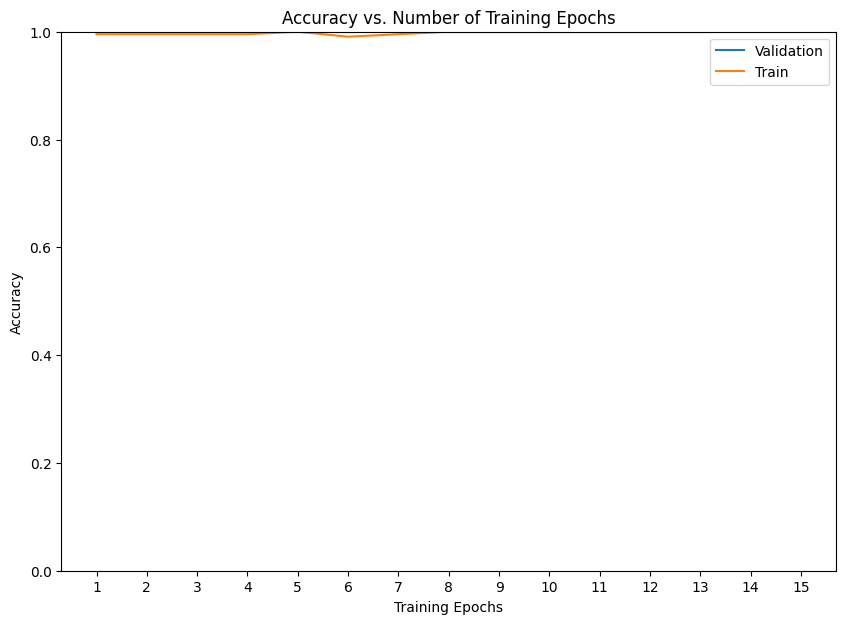

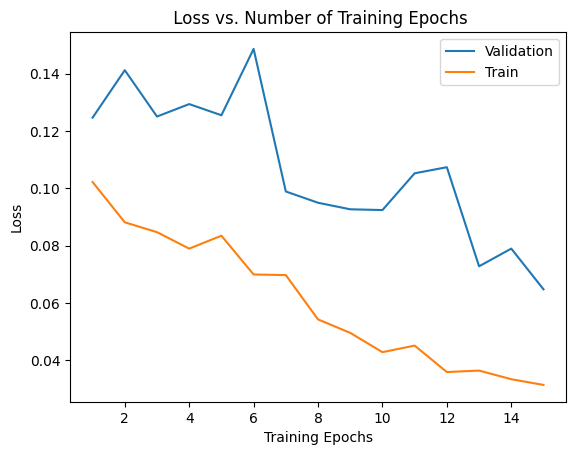

In [97]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method


# Plot Validation and Training Accuracy
plt.figure(figsize=(10, 7))
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
# Convert each tensor in the list to a numpy array after moving it to CPU
plt.plot(range(1, NUM_EPOCHS + 1), [t.cpu().item() for t in hist[0]], label="Validation")
plt.plot(range(1, NUM_EPOCHS + 1), [t.cpu().item() for t in hist[2]], label="Train")
plt.ylim((0, 1.))
plt.xticks(np.arange(1, NUM_EPOCHS + 1, 1.0))
plt.legend()
plt.show()

# Plot Validation and Training Loss
plt.title(" Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,NUM_EPOCHS+1),hist[1],label="Validation")
plt.plot(range(1,NUM_EPOCHS+1),hist[3],label="Train")
plt.legend()
plt.show()

Visualize some model Predictions

In [98]:
model_test, input_size = initialize_model(MODEL_NAME, NUM_CLASSES, WIDTH, CHANNELS, FEATURE_EXTRACT, use_pretrained=True)
model_test.load_state_dict(loaded_checkpoint['model_state'])
model_test.to(device)
model_test.eval()

test_transforms_print = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor()
                                     ])

test_transforms_predict = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
                                     ])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [108]:
def get_random_images(num):
    data = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = test_transforms_print)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data,sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = next(dataiter)
    return images, labels


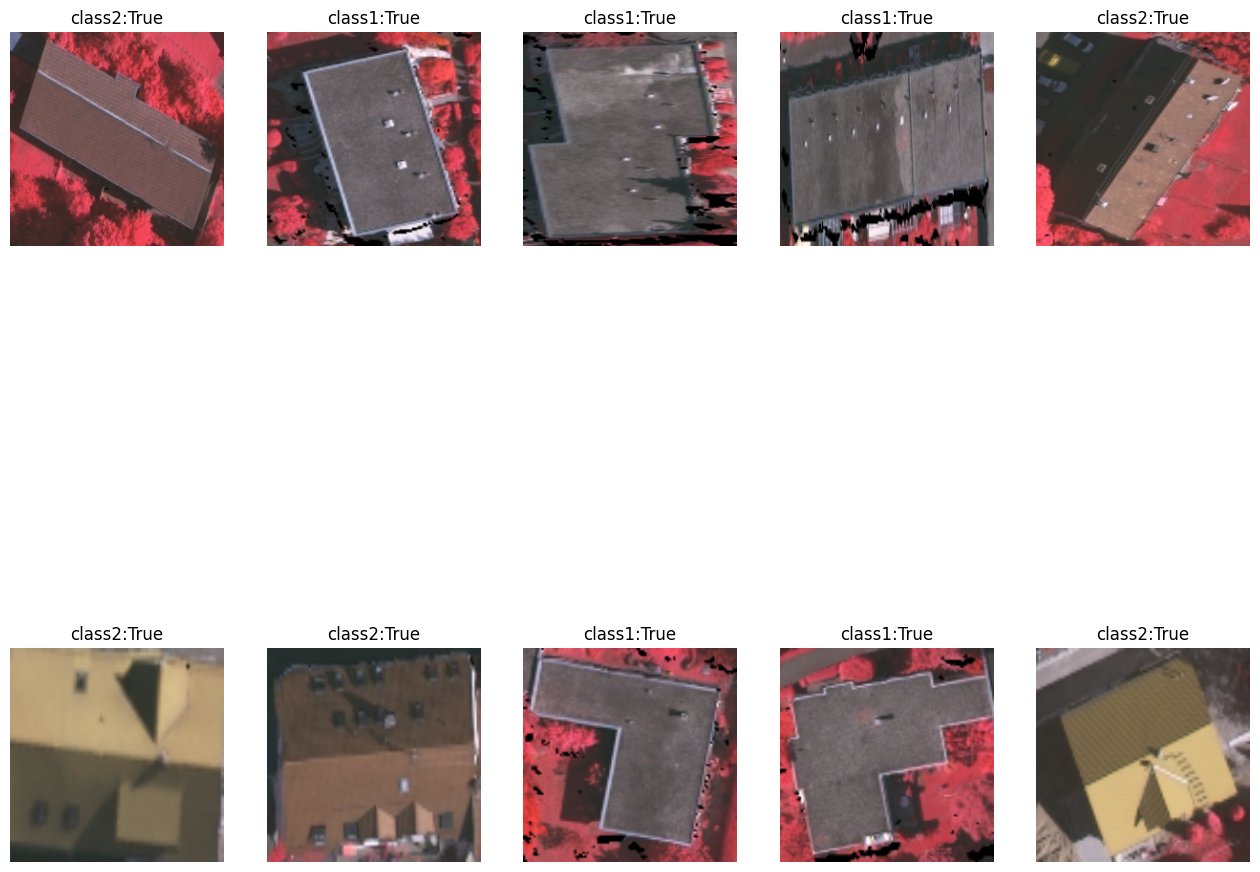

In [112]:
# Import Some Random Images
to_pil = transforms.ToPILImage()
images, labels = get_random_images(10)
fig=plt.figure(figsize=(16, 16))
classes = train_dataset.classes
gpu_images = images.clone()


for i in range(gpu_images.shape[0]):
    gpu_images[i,:,:,:] = test_transforms_predict(gpu_images[i,:,:,:])

gpu_images = gpu_images.to(device)

# Make predictions on them
outputs = model_test(gpu_images)
_, preds = torch.max(outputs, 1)
preds = preds.data.cpu().numpy()

labels = labels.cpu().numpy()

import math
# Plot the results
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = preds[ii]
    sub = fig.add_subplot(2, math.ceil(len(images)/2), ii+1)
    fig.subplots_adjust(hspace=0.0, wspace=0.2)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
    #plt.savefig('Model Predictions.png')
plt.show()


Confusion Matrix

Compute confusion matrix to evaluate the accuracy of a classification.

Our Classes: 'destroyed': 0, 'not-destroyed': 1

By definition a confusion matrix $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group i and predicted to be in group j.

Thus in binary classification, the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$.

In [126]:
start = time.time()

CF = np.zeros((2,2))
wrong_validation_examples = []

for examples, true_labels in dataloaders_dict['val']:
  examples = examples.to(device)
  with torch.no_grad():
    outputs = model_test(examples)
    _, preds = torch.max(outputs, 1)

  wrong_indices = np.nonzero(true_labels.numpy() - preds.data.cpu().numpy())
  wrong_validation_examples.append((examples.cpu().numpy()[wrong_indices] , true_labels.numpy()[wrong_indices]))
  CF += confusion_matrix(true_labels.numpy(), preds.data.cpu().numpy())


print(CF)

end = time.time()
print('total time: ', end - start)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[[12.  0.]
 [ 0. 12.]]
total time:  0.630183219909668


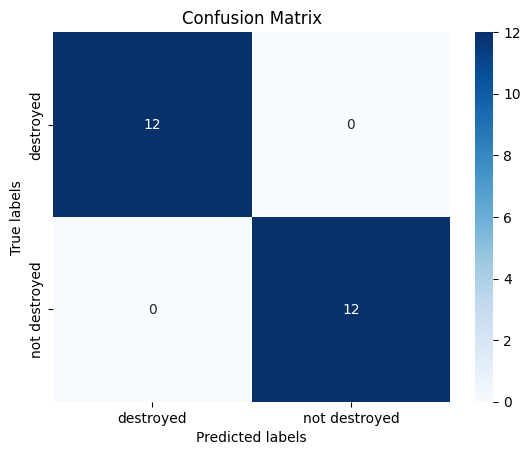

In [127]:
ax= plt.subplot()
sns.heatmap(CF, annot=True, ax = ax, cmap='Blues', fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['destroyed', 'not destroyed']); ax.yaxis.set_ticklabels(['destroyed', 'not destroyed']);
#plt.savefig('CM.png')

In [128]:
True_destroyed = 1360 / (1360 + 38)
print(True_destroyed)
False_destroyed = 66 / (1104 + 66)
print(False_destroyed)

0.9728183118741058
0.05641025641025641


In [139]:
tp = CF[1,1]
tn = CF[0,0]
fp = CF[0,1]
fn = CF[1,0]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F1 = 2 * tp / (2*tp + fp + fn)

IndexError: list index out of range

In [130]:
wrong_validation_examples_tuple = []
for ii in range(len(wrong_validation_examples)):
  for jj in range(len(wrong_validation_examples[ii][0])):
    wrong_validation_examples_tuple.append((wrong_validation_examples[ii][0][jj], wrong_validation_examples[ii][1][jj]))

In [136]:
to_pil(torch.tensor(wrong_validation_examples_tuple[0][0]))

IndexError: list index out of range

Print Images predicted incorrectly

In [132]:
original_wrong_images = []
original_wrong_labels = []

for i in range(len(wrong_validation_examples_tuple)):
    reconstructed_image = np.zeros((3, 224, 224))
    reconstructed_image[0, :, :] = wrong_validation_examples_tuple[i][0][0, :, :] * 0.229 + 0.485
    reconstructed_image[1, :, :] = wrong_validation_examples_tuple[i][0][1, :, :] * 0.224 + 0.456
    reconstructed_image[2, :, :] = wrong_validation_examples_tuple[i][0][2, :, :] * 0.225 + 0.406
    original_wrong_images.append(to_pil(torch.tensor(np.float32(reconstructed_image))))
    original_wrong_labels.append(wrong_validation_examples_tuple[i][1])

print(len(original_wrong_labels))

0


In [133]:
num_images_to_print = 10
indices = list(range(len(wrong_validation_examples_tuple)))
np.random.shuffle(indices)
idx = indices[:num_images_to_print]
images_to_print = []
labels_to_print = []

for ii in range(len(idx)):
  images_to_print.append(original_wrong_images[idx[ii]])
  labels_to_print.append(original_wrong_labels[idx[ii]])

fig=plt.figure(figsize=(16, 16))
classes = train_dataset.classes

for ii in range(num_images_to_print):
    image = images_to_print[ii]
    label = labels_to_print[ii]
    sub = fig.add_subplot(2, int(num_images_to_print/2), ii+1)
    sub.set_title('true label' + ': ' + str(classes[label]))
    plt.axis('off')
    plt.imshow(image)
    #plt.savefig('Model Wrong Predictions.png')
plt.show()


IndexError: list index out of range

<Figure size 1600x1600 with 0 Axes>

Save Model or Checkpoint

In [ ]:
# FILE = "model_ft.pth"
# # torch.save(model_ft.state_dict(), FILE)

# checkpoint = {
#     "epoch" : num_epochs,
#     "model_state" : model_ft.state_dict(),
#     "optim_state" : optimizer_ft.state_dict()
# }
# CHECKPOINT_PATH = "damaged_structures_detector/checkpoints/checkpoint.pth"
# torch.save(checkpoint, CHECKPOINT_PATH)

Load Model (Needs initialization first)

In [ ]:
# # loaded_model, input_size = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# # loaded_model.load_state_dict(torch.load(FILE))
# # loaded_model.eval()

# loaded_checkpoint = torch.load(CHECKPOINT_PATH)
# epoch = checkpoint["epoch"]
# model_state = checkpoint["model_state"]
# optim_state = checkpoint["optim_state"]

# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# optimizer_ft.load_state_dict(optim_state)

Save on GPU, Load on CPU

In [ ]:
# device = torch.device("cuda")
# model.to(device)
# torch.save(model.state_dict(), FILE)

# device = torch.device('cpu')
# model = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# model.load_state_dict(torch.load(FILE, map_location=device))

Save GPU, Load GPU

In [ ]:
# device = torch.device("cuda")
# model.to(device)
# torch.save(model.state_dict(), FILE)

# model = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# model.load_state_dict(torch.load(FILE))
# model.to(device)

Save CPU, Load GPU

In [ ]:
# torch.save(model_ft.state_dict(), FILE)

# device = torch.device("cuda")
# model = initialize_model(model_name, num_classes, width, channels, feature_extract, use_pretrained=True)
# model.load_state_dict(torch.load(FILE, map_location="cuda:0"))
# model.to(device)